# Regressão Logística Multinomial

Já vimos a regressão logística binomial, em que a variável $y$ só assume dois valores, agora iremos tratar de problemas em que a variável $y$ assume mais de dois valores, essa é chamada regressão logística multinomial.

A função que usaremos para implementar a regressão logística multinomial é dada por $$p(x) = \frac{1}{1 + e^{-(b_0 + b_1 x_1 + \cdots + b_n x_n)}}$$

em que $x_1, \ldots, x_n$ são as variáveis utilizadas para prever $y$ e $b_0, b_1, \ldots, b_n$ são os coeficientes do modelos a serem estimados. Esses coeficientes devem ser tais que a função $p(x)$ obtenha a melhor taxa possível de classificação de $y$, dado $x$; isto, em geral, é feito maximizando a função de [log verossimilhança](https://pt.wikipedia.org/wiki/Fun%C3%A7%C3%A3o_de_verossimilhan%C3%A7a).

A função $p(x)$ é normalmente interpretada como a probabilidade de que $y$ seja 1, dado $x$. Consequentemente, $1-p(x)$ é a probabilidade de que $y$ seja 0, dado $x$.


Você deve estar se perguntando "Como vamos adaptar a regressão logística que só servia para duas classes para o caso de mais classes?". Existe mais de uma forma de fazer isso, podemos, por exemplo, considerar classe 0 e não 0 e ajustar 1 modelo de regressão logística; após isso a classe não 0 é dividida em 1 e não 1, e ajusta-se outro modelo de regressão logística e assim sucessivamente até dividir todas as classes.

Vejamos isso na prática!

Será que podemos estimar o `% de pobres` com base na `Porcentagem de Ativos`  e no `IDH` para o estado de Minas Gerais? Será que podemos obter alguma interpretação de tal modelo?

A variável `Porcentagem de Ativos` é a porcentagem da população em idade economicamente ativa (entre 25 e 64 anos).

Nós já lidamos com esse problema na parte de regressão linear, vejamos outra abordagem possível.

In [75]:
# Dependências externas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [76]:
df_original = pd.read_csv('2.3_Regressao_Logistica_Multinomial_Dados.csv')
df_original.head(2)

,nomeLocalidade,estado,População residente,Densidade demográfica,Porcentagem de Jovens,Porcentagem de Ativos,Porcentagem de Idosos,Taxa de Urbanização,Taxa de Saneamento Básico,Ativos com Baixo Nível Educacional,...,Percentual de empresas do setor terciário em relação ao total,Percentual de trabalhadores do setor primário em relação ao total,Percentual de trabalhadores do setor secundário em relação ao total,Percentual de trabalhadores do setor terciário em relação ao total,Média Salarial,Produtividade,Taxa de desemprego dos jovens,Taxa de desemprego,"Número de trabalhadores(Comerciais, hotéis e restaurantes) por 1,000 habitantes","Número de ativos culturais e de lazer por 10,000 habitantes"
0,Acrelândia,Acre,12538,6.93,52.92,43.04,4.04,48.34,0.00,75.34,...,75.41,8.86,21.53,34.07,994.67,2654247.23,19.17,9.62,12.12,0.0
1,Assis Brasil,Acre,6072,1.22,55.58,40.07,4.35,65.30,2.39,66.83,...,100.00,0.60,0.00,36.25,1163.49,2113108.99,10.57,7.44,17.79,0.0


Vamos selecionar apenas as variáveis `Porcentagem de Ativos`, `IDH` e `% de pobres` para o estado de Minas Gerais.

In [77]:
df = df_original.loc[df_original['estado'] == 'Minas Gerais', ['Porcentagem de Ativos', 'IDH', '% de pobres']].reset_index(drop=True)
df.head()

,Porcentagem de Ativos,IDH,% de pobres
0,55.83,0.84,7.94
1,52.61,0.85,6.69
2,50.31,0.82,23.33
3,48.35,0.82,26.53
4,45.88,0.84,30.70


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Porcentagem de Ativos  853 non-null    float64
 1   IDH                    853 non-null    float64
 2   % de pobres            853 non-null    float64
dtypes: float64(3)
memory usage: 20.1 KB


In [79]:
# Verificando a correlação linear entre as variáveis
df.corr()

,Porcentagem de Ativos,IDH,% de pobres
Porcentagem de Ativos,1.000000,0.650718,-0.831380
IDH,0.650718,1.000000,-0.721518
% de pobres,-0.831380,-0.721518,1.000000


Agora precisamos criar uma variável categórica para a variável `% de pobres`. Para isso vamos obter os quartis para a variável `% de pobres`.

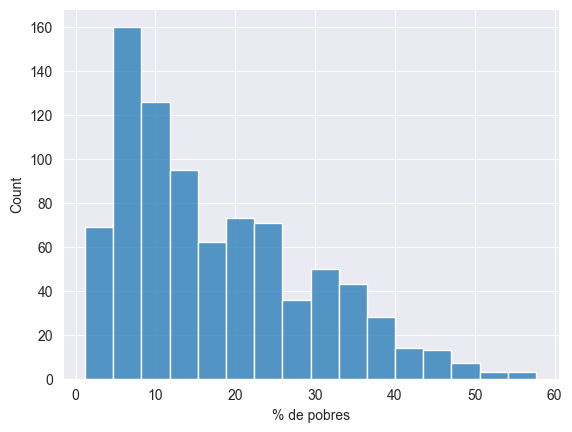

In [80]:
# Gerando histograma
sns.histplot(df['% de pobres']);

In [81]:
# Obter os quartis da variável % de pobres
quantiles = df['% de pobres'].quantile([0, 0.25, 0.5, 0.75, 1])
print(quantiles)

0.00     1.18
0.25     7.90
0.50    14.09
0.75    24.83
1.00    57.66
Name: % de pobres, dtype: float64


Faremos isso da seguinte forma: se o valor da variável `% de pobres` for menor que a 7.9, iremos atribuir o valor 0; se estiver entre 7.9 e 14.09, iremos atribuis o valor 1; se estiver entre 14.09 e 24.83, iremos atribuir o valor 2; caso contrário iremos atribuir 3.

Ao fazer isso estamos considerando que 0 indica baixa porcentagem de pobres; 1 indica valor moderado de porcentagem de pobres; 2 indica valor alto, e 3 indica valor muito alto.

Vamos criar condições e valores para serem usados na criação da coluna categórica.

In [82]:
# Criando lista de condições

conditions = [
    (df['% de pobres'] <= quantiles[0.25]),
    (df['% de pobres'] > quantiles[0.25]) & (df['% de pobres'] <= quantiles[0.50]),
    (df['% de pobres'] > quantiles[0.50]) & (df['% de pobres'] <= quantiles[0.75]),
    (df['% de pobres'] > quantiles[0.75]),
]

# Criando lista de valores
values = [0, 1, 2, 3]

# Criando a coluna categórica
df['% de pobres cat'] = np.select(conditions, values)
df.head()

,Porcentagem de Ativos,IDH,% de pobres,% de pobres cat
0,55.83,0.84,7.94,1
1,52.61,0.85,6.69,0
2,50.31,0.82,23.33,2
3,48.35,0.82,26.53,3
4,45.88,0.84,30.70,3


Poderíamos fazer a classificação dos grupos usando outras técnicas, como agrupamento.

Vamos observar se as classes estão balanceadas.

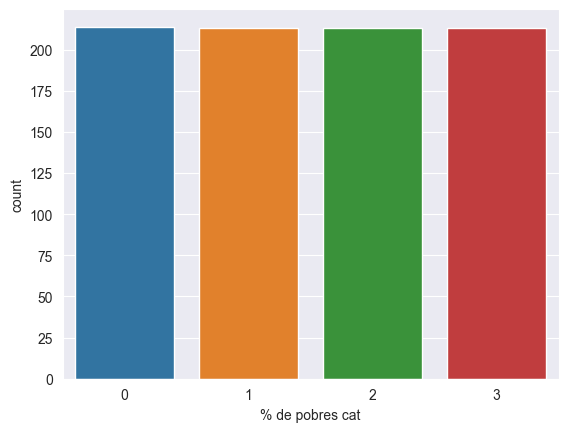

In [83]:
sns.countplot(x=df['% de pobres cat']);

In [84]:
# Criando as variáveis X e y
X = df[['Porcentagem de Ativos', 'IDH']]
y = df['% de pobres cat']

Vamos usar a biblioteca `statsmodels` para criar o modelo de regressão logística, embora isso também pudesse ser feito com o `scikit-learn`.

Assim como na regressão linear, temos que adicionar uma constante à variável X.

In [85]:
# Adicionando a constante
X = sm.add_constant(X)

In [86]:
# Criando o modelo
model = MNLogit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.846556
         Iterations 8


In [87]:
model.predict(X)

,0,1,2,3
0,0.635116,0.327047,0.037729,0.000108
1,0.519040,0.378361,0.101138,0.001461
2,0.095662,0.347584,0.492148,0.064606
3,0.034516,0.193585,0.544478,0.227422
4,0.024330,0.113506,0.426838,0.435326
...,...,...,...,...
848,0.019569,0.113695,0.452231,0.414506
849,0.000250,0.006734,0.126403,0.866613
850,0.509316,0.382118,0.106899,0.001667
851,0.177445,0.373769,0.399840,0.048946


Também conseguimos fazer previsões. Para o modelo de regressão logística do `statsmodels` a previsão retornará apenas a probabilidade de se estar em cada categoria. Precisamos fazer um pequeno tratamento para obtermos apenas 0, 1, 2 ou 3.

In [88]:
y_pred = model.predict(X).idxmax(axis=1)
y_pred

0      0
1      0
2      2
3      2
4      3
      ..
848    2
849    3
850    0
851    2
852    0
Length: 853, dtype: int64

Podemos também obter algumas informações do modelos com o método `summary()`.

In [89]:
print(model.summary())

                          MNLogit Regression Results                          
Dep. Variable:        % de pobres cat   No. Observations:                  853
Model:                        MNLogit   Df Residuals:                      844
Method:                           MLE   Df Model:                            6
Date:                Fri, 11 Aug 2023   Pseudo R-squ.:                  0.3893
Time:                        13:16:49   Log-Likelihood:                -722.11
converged:                       True   LL-Null:                       -1182.5
Covariance Type:            nonrobust   LLR p-value:                1.203e-195
    % de pobres cat=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    42.4150      5.234      8.104      0.000      32.156      52.674
Porcentagem de Ativos    -0.2215      0.062     -3.584      0.000      -0.343      -0.100
IDH     

## Medindo a Performance

In [90]:
# Gerando a matriz de confusão
cm = confusion_matrix(y, y_pred)
cm

array([[152,  52,  10,   0],
       [ 73,  79,  58,   3],
       [ 15,  49, 113,  36],
       [  0,   0,  42, 171]])

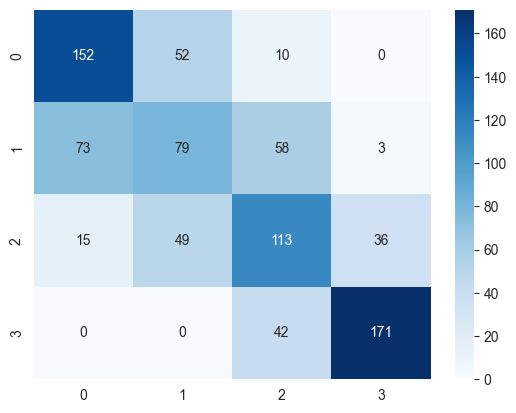

In [91]:
# Gerando o mapa de calor
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d');

Também podemos obter o mapa de calor observando os valores percentuais.

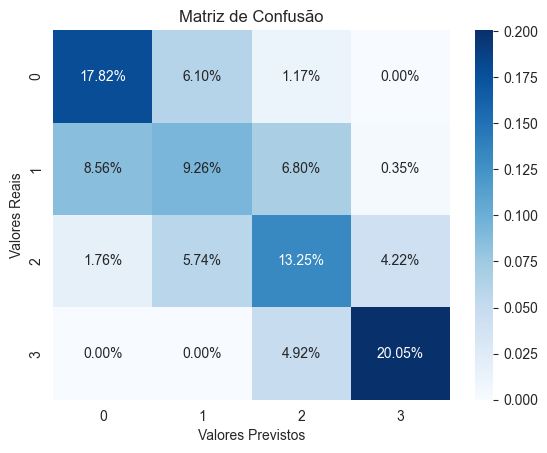

In [92]:
# Gerando mapa de valor com valores percentuais
sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues', fmt='.2%')
plt.title('Matriz de Confusão')
plt.ylabel('Valores Reais')
plt.xlabel('Valores Previstos');

Para observar as outras métricas, podemos usar a função `classification_report` do módulo `metrics` do `scikit-learn`.

In [93]:
# Imprimindo o classification report
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67       214
           1       0.44      0.37      0.40       213
           2       0.51      0.53      0.52       213
           3       0.81      0.80      0.81       213

    accuracy                           0.60       853
   macro avg       0.60      0.60      0.60       853
weighted avg       0.60      0.60      0.60       853



Podemos ver que a acurária é de 60%, indicando que o modelo acerta 60% da previsões. Note também que ele se sai razoavelmente bem na classe 3, mas se sai mal na classe 1. Isto indica que o modelo não está muito bom.

Outra métrica é área sob a curva ROC. Podemos obter essa métrica e criar um gráfico da curva ROC com as funções `roc_curve` e `roc_auc_score` do módulo `metrics` do `scikit-learn`.

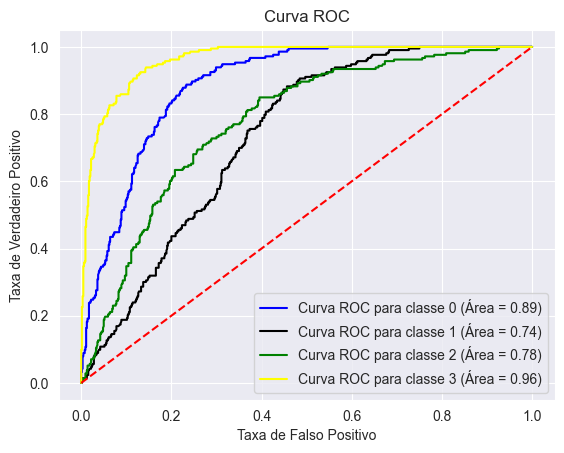

In [97]:
# Criando colunas com valores binários para cada categoria
y_cat = label_binarize(y, classes=[0, 1, 2, 3])
fpr = {}
tpr = {}
roc_auc = {}
n_classes = 4
colors = ['blue', 'black', 'green', 'yellow']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_cat[:, i], model.predict(X).iloc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'Curva ROC para classe {i} (Área = {round(roc_auc[i], 2)})')

plt.plot([0, 1], [0, 1], 'r--')
plt.legend(loc='lower right')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC');

Podemos ver que cada classe possui sua curva ROC e a área sob as curvas muda de classe para classe, indicando que o modelo está melhor em algumas classes do que outras.